<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Импорты" data-toc-modified-id="Импорты-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импорты</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подберем-параметры-для-случайного-леса" data-toc-modified-id="Подберем-параметры-для-случайного-леса-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Подберем параметры для случайного леса</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#Catboost" data-toc-modified-id="Catboost-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Catboost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Импорты

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.dummy import DummyRegressor
import lightgbm as lgb
import time
warnings.filterwarnings('ignore')

## Подготовка

In [2]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
df = df.sort_index()

In [6]:
df.index.is_monotonic

True

Данные идут с периодичностью в 10 минут, ресемплирую их

In [7]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Анализ

Выведем график временного ряда ресемплированного по часам

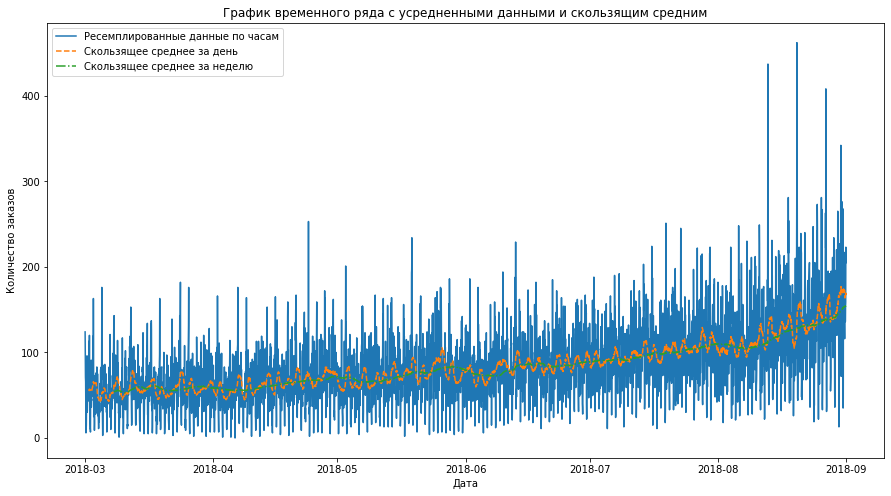

In [9]:
df_resampled = df.resample('H').mean()

df_resampled['MA_day'] = df_resampled['num_orders'].rolling(window=24).mean()
df_resampled['MA_week'] = df_resampled['num_orders'].rolling(window=24*7).mean()

plt.figure(figsize=(15, 8))
plt.plot(df_resampled['num_orders'], label='Ресемплированные данные по часам')
plt.plot(df_resampled['MA_day'], label='Скользящее среднее за день', linestyle='--')
plt.plot(df_resampled['MA_week'], label='Скользящее среднее за неделю', linestyle='-.')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.title('График временного ряда с усредненными данными и скользящим средним')
plt.legend()
plt.show()

In [10]:
df_resampled

,num_orders,MA_day,MA_week
datetime,,,
2018-03-01 00:00:00,124,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN
...,...,...,...
2018-08-31 19:00:00,136,167.541667,154.434524
2018-08-31 20:00:00,154,168.041667,154.285714
2018-08-31 21:00:00,159,166.416667,154.244048


Рассмотрим тренды и сезонность данных за весь период

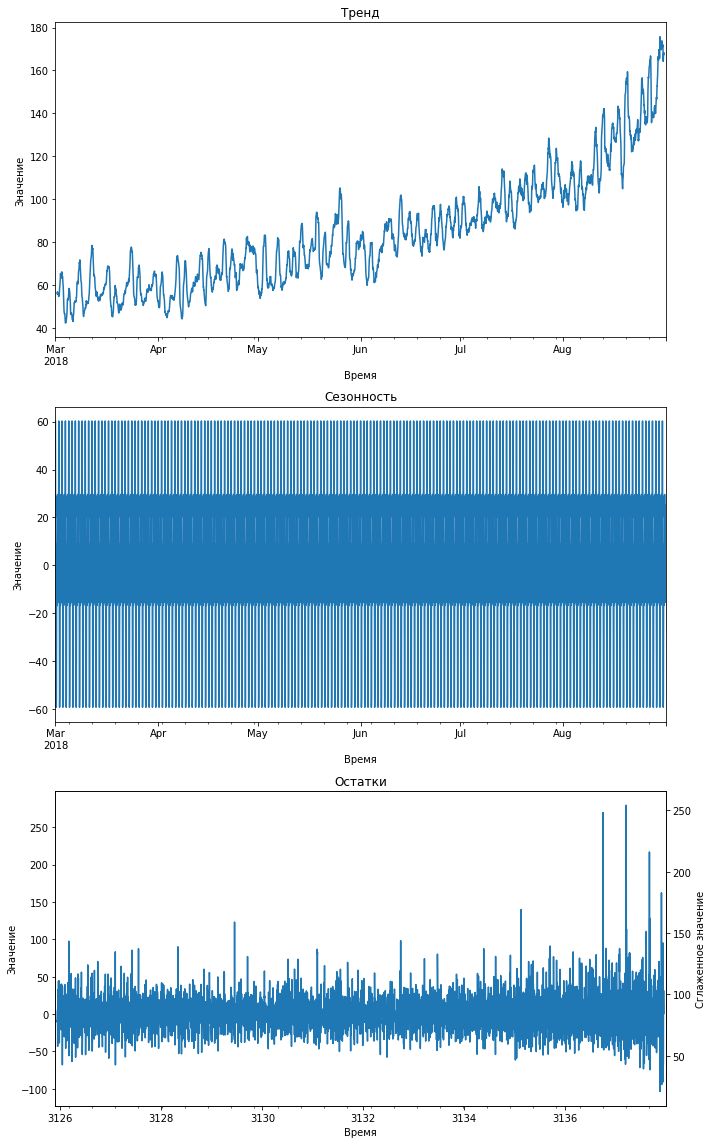

In [11]:
decompose = seasonal_decompose(df)

plt.figure(figsize=(10, 16))
plt.subplot(311)
decompose.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Время')
plt.ylabel('Значение')


plt.subplot(312)
decompose.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Время')
plt.ylabel('Значение')

plt.subplot(313)
decompose.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.xlabel('Время')
plt.ylabel('Значение')

plt.gca().twinx().plot(df.rolling(window=7, center=True).mean(), color='red', alpha=0.5)
plt.ylabel('Сглаженное значение')

plt.tight_layout()
plt.show()

За неделю, взяла с понедельника последней полной недели

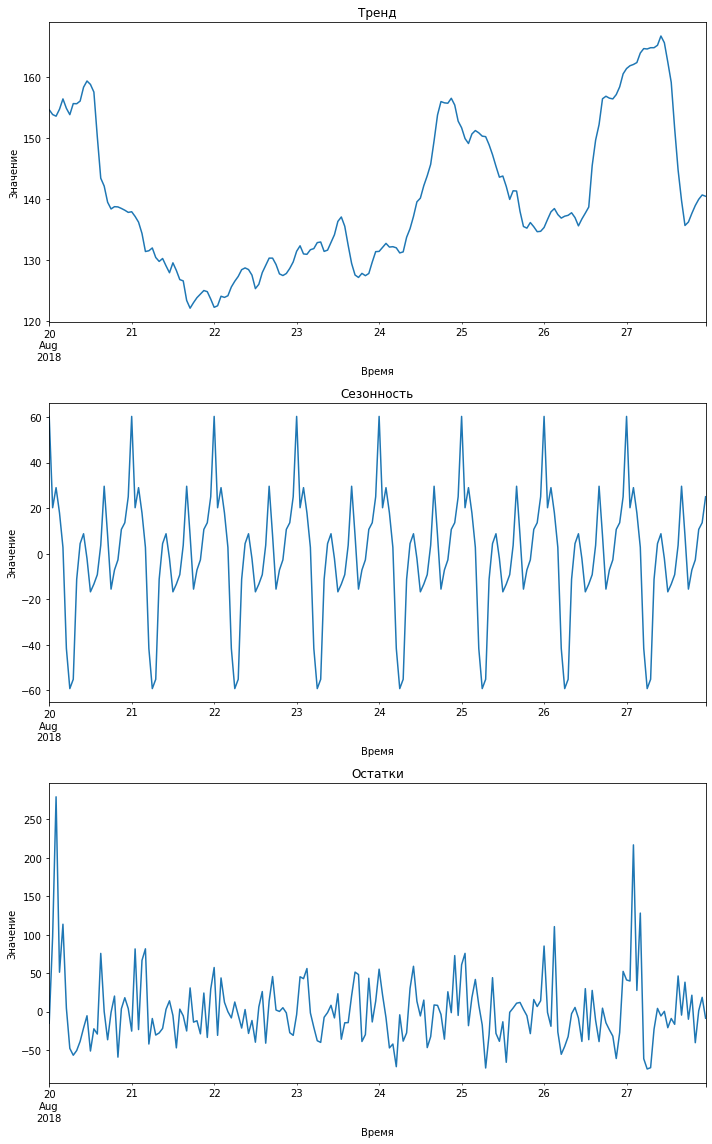

In [12]:
decompose = seasonal_decompose(df)

plt.figure(figsize=(10, 16))
plt.subplot(311)

decompose.trend['2018-08-20':'2018-08-27'].plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.subplot(312)

decompose.seasonal['2018-08-20':'2018-08-27'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.subplot(313)

decompose.resid['2018-08-20':'2018-08-27'].plot(ax=plt.gca())
plt.title('Остатки')
plt.xlabel('Время')
plt.ylabel('Значение')


plt.tight_layout()
plt.show()

За день

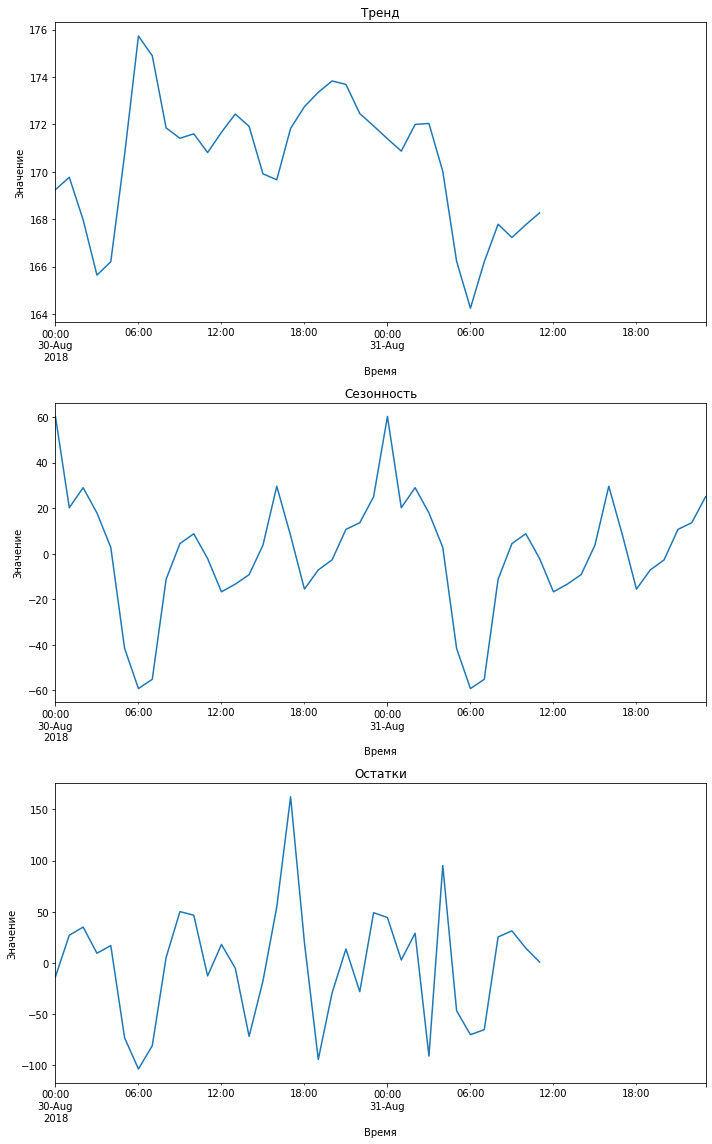

In [13]:
decompose = seasonal_decompose(df)

plt.figure(figsize=(10, 16))
plt.subplot(311)

decompose.trend['2018-08-30':'2018-08-31'].plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.subplot(312)

decompose.seasonal['2018-08-30':'2018-08-31'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.subplot(313)

decompose.resid['2018-08-30':'2018-08-31'].plot(ax=plt.gca())
plt.title('Остатки')
plt.xlabel('Время')
plt.ylabel('Значение')

plt.tight_layout()
plt.show()

Количество заказов увеличивается к второй половине недели, а после понедельника начинает падать. Можно увидеть высокий спрос ближе к 18, возможно в это время много рейсов по расписанию. Также можно увидеть сплеск ближе к 6 утра, возможно это тоже связанно с повышенным количеством рейсов в это время. Общий тренд возрастающий

Нулевая гипотеза гласит: "Временной ряд является нестацинарным". Альтернативная: "Временной ряд стационарен"

In [14]:
p_value = adfuller(df['num_orders'])[1]
print('P =', p_value)
if p_value < 0.05:
    print('Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера')
else:
    print('Нулевая гипотеза не отвергается. Ряд нестационарен по критерию Дики-Фуллера')

P = 0.028940051402612906
Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера


In [15]:
p_value = adfuller(df['num_orders'])[1]
print('P =', p_value)
if p_value < 0.01:
    print('Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера')
else:
    print('Нулевая гипотеза не отвергается. Ряд нестационарен по критерию Дики-Фуллера')

P = 0.028940051402612906
Нулевая гипотеза не отвергается. Ряд нестационарен по критерию Дики-Фуллера


На уровне более высоком уровне доверия ряд становится нестационарным

## Обучение

Нам понадобятся признаки day, так как есть явный тренд в течении дня и  dayofweek

In [16]:
def make_features(df, max_lag, rolling_mean_size):
    
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

In [17]:
make_features(df, 24, 20)
df.shape

(4416, 28)

In [18]:
df

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,31,4,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,169.35
2018-08-31 20:00:00,154,31,4,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,163.85
2018-08-31 21:00:00,159,31,4,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,157.75


Поделим выборку на train, valid и test

In [19]:
train,test = train_test_split(df,shuffle=False, random_state=12345, test_size = 0.1)
train = train.dropna()

In [20]:
train.shape

(3950, 28)

In [21]:
test.shape

(442, 28)

In [22]:
(train_features, test_features) = (train.drop('num_orders',axis = 1), test.drop('num_orders',axis = 1))
(train_target, test_target) = (train['num_orders'], test['num_orders'])

In [23]:
print(train_features.shape)
print(train_target.shape)

(3950, 27)
(3950,)


In [24]:
print(test_features.shape)
print(test_target.shape)

(442, 27)
(442,)


### Подберем параметры для случайного леса

In [25]:
splits = TimeSeriesSplit(n_splits=3)

In [26]:
scorer = make_scorer(mean_squared_error, squared=False)

In [27]:
RF = RandomForestRegressor(random_state=42)
parametrs = {"max_depth": [1,10],"n_estimators":[100,150,10]}

RF_grid = GridSearchCV(RF, parametrs, cv=splits, scoring=scorer, verbose=True, n_jobs=-1)

In [28]:
RF_grid.fit(train_features,train_target)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [1, 10], 'n_estimators': [100, 150, 10]},
             scoring=make_scorer(mean_squared_error, squared=False),
             verbose=True)

In [29]:
best_score_RF = RF_grid.best_score_
print("Оценка на кросс-валидации:", best_score_RF)

Оценка на кросс-валидации: 36.528910271598846


### LightGBM

In [30]:
param_dist = {"max_depth": sp_randint(5, 15),
              "learning_rate": [0.01, 0.05, 0.1, 0.2],
              "n_estimators": sp_randint(100, 1000)}

model_lgb = lgb.LGBMRegressor(metric='l2')

random_search_lgb = RandomizedSearchCV(model_lgb, param_distributions=param_dist, n_iter=10, scoring='neg_root_mean_squared_error')

random_search_lgb.fit(train_features, train_target)

RandomizedSearchCV(estimator=LGBMRegressor(metric='l2'),
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f68a4c27dc0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f68a5622ee0>},
                   scoring='neg_root_mean_squared_error')

In [31]:
best_params_lgb = random_search_lgb.best_params_
print("Лучшие параметры:", best_params_lgb)

best_score_lgb = random_search_lgb.best_score_
print("Оценка на кросс-валидации:", abs(best_score_lgb))

Лучшие параметры: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 227}
Оценка на кросс-валидации: 24.070784442822834


### Catboost

In [32]:
catboost = CatBoostRegressor(loss_function='RMSE',random_state = 42)
parameters_cat = {'depth':[5,10], 'learning_rate':np.arange(0.1,1,0.2)}
catboost_grid = GridSearchCV(catboost, parameters_cat, cv=splits, verbose=True, scoring='neg_root_mean_squared_error')
catboost_grid.fit(train_features, train_target)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
0:	learn: 28.0658554	total: 50.3ms	remaining: 50.2s
1:	learn: 26.8144941	total: 52.3ms	remaining: 26.1s
2:	learn: 25.8809999	total: 54.4ms	remaining: 18.1s
3:	learn: 25.0100048	total: 56.7ms	remaining: 14.1s
4:	learn: 24.1427795	total: 58.8ms	remaining: 11.7s
5:	learn: 23.4498905	total: 60.8ms	remaining: 10.1s
6:	learn: 22.7821429	total: 62.8ms	remaining: 8.91s
7:	learn: 22.2954609	total: 64.9ms	remaining: 8.04s
8:	learn: 21.7951565	total: 67ms	remaining: 7.38s
9:	learn: 21.4298535	total: 69ms	remaining: 6.83s
10:	learn: 21.0228527	total: 71.1ms	remaining: 6.39s
11:	learn: 20.6724812	total: 73ms	remaining: 6.01s
12:	learn: 20.3111478	total: 75.1ms	remaining: 5.7s
13:	learn: 20.0589748	total: 77.3ms	remaining: 5.44s
14:	learn: 19.8338654	total: 79.3ms	remaining: 5.21s
15:	learn: 19.5791431	total: 81.4ms	remaining: 5.01s
16:	learn: 19.3200361	total: 83.5ms	remaining: 4.83s
17:	learn: 19.1282493	total: 85.6ms	remaining: 4.67s
18

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7f68a4c3f700>,
             param_grid={'depth': [5, 10],
                         'learning_rate': array([0.1, 0.3, 0.5, 0.7, 0.9])},
             scoring='neg_root_mean_squared_error', verbose=True)

In [33]:
best_score_cat = catboost_grid.best_score_
print("Оценка на кросс-валидации:", -best_score_cat)

Оценка на кросс-валидации: 26.763132883860056


Лучшее значение RMSE на кросс-валидации получилось у модели LightGBM -  24.01. Данную модель мы и будем тестировать

## Тестирование

Проверим RMSE на тестовой выборке у модели LightGBM, так как она дала лучший показатель на кросс-валидации.

In [34]:
predictions = random_search_lgb.best_estimator_.predict(test_features)

In [35]:
rmse = np.sqrt(mean_squared_error(test_target, predictions))
print("RMSE модели LightGBM на тестовой выборке", rmse)

RMSE модели LightGBM на тестовой выборке 42.23189352221267


На тестовой выбоке результат модели LightGBM равен 42.11, что соответствует требованиям проекта

Сравним качество с константной моделью

In [36]:
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(train_features, train_target)

lgb_test_pred = random_search_lgb.best_estimator_.predict(test_features)
rmse_lgb_test = mean_squared_error(test_target, lgb_test_pred)**0.5

dummy_test_pred = dummy_model.predict(test_features)
rmse_dummy_test = mean_squared_error(test_target, dummy_test_pred)**0.5

print('Значение RMSE на тестовой выборке у лучшей модели', rmse_lgb_test)
print('Значение RMSE на тестовой выборке у константной модели', rmse_dummy_test)

if rmse_lgb_test < rmse_dummy_test:
    print("Модель LightGBM лучше по сравнению с константной моделью.")
elif rmse_lgb_test > rmse_dummy_test:
    print("Константная модель лучше по сравнению с моделью LightGBM")
else:
    print("Модель LightGBM и константная модель показывают одинаковое качество.")

Значение RMSE на тестовой выборке у лучшей модели 42.23189352221267
Значение RMSE на тестовой выборке у константной модели 84.6499381993622
Модель LightGBM лучше по сравнению с константной моделью.


## Вывод

Мы загрузили данные и выполнили их ресемплирование по одному часу. Изучили данные и выявили некоторые тенденции. На протяжении всего периода мы видим возрастающую тенденцию. В течении недели имеется закономерность: ближе ко второй половине недели спрос возрастает, а к концу понедельника падает. В течении дня есть два пика - ближе к 18 и ночью. 

Далее мы выбрали три модели (Randomforest, LightGBM и Catboost), подобрали гиперпараметры для них и обучили. На кросс-валидации лучшее значение RMSE показала модель LightGBM.